In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
for row in session.query(Measurement.date, Measurement.prcp).limit(15).all():
    print(row)

('2010-01-01', 0.08)
('2010-01-02', 0.0)
('2010-01-03', 0.0)
('2010-01-04', 0.0)
('2010-01-06', None)
('2010-01-07', 0.06)
('2010-01-08', 0.0)
('2010-01-09', 0.0)
('2010-01-10', 0.0)
('2010-01-11', 0.01)
('2010-01-12', 0.0)
('2010-01-14', 0.0)
('2010-01-15', 0.0)
('2010-01-16', 0.0)
('2010-01-17', 0.0)


In [11]:
# Calculate the date 1 year ago from the last data point in the database
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date

('2017-08-23')

In [12]:
query_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
query_date

datetime.date(2016, 8, 23)

In [13]:
# Perform a query to retrieve the data and precipitation scores
precipitation = session.query(Measurement.date, func.max(Measurement.prcp)).\
    filter(Measurement.date > query_date).\
    group_by(Measurement.date).\
    order_by(Measurement.date).all()

In [14]:
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
precipitation_summary = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= query_date).\
    order_by(Measurement.date).all()
prcp_sum_df = pd.DataFrame(precipitation_summary)
prcp_sum_df = prcp_sum_df.rename(columns={"prcp":"precipitation"})
prcp_sum_df = prcp_sum_df.set_index("date")
prcp_sum_df.head()

,precipitation
date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,NaN
2016-08-23,0.02


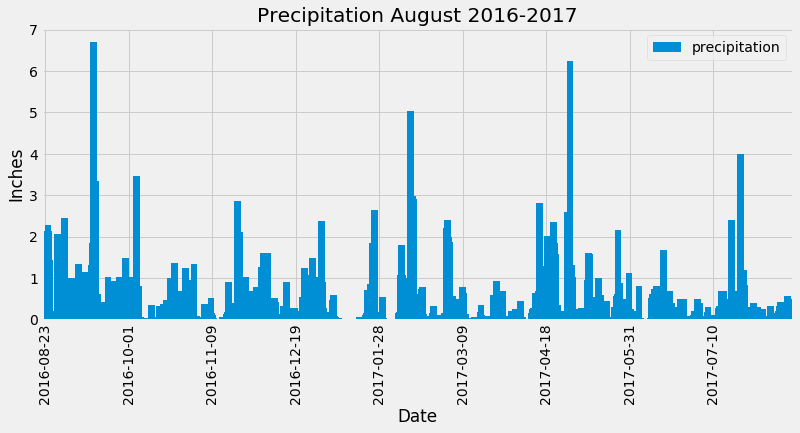

In [15]:
# Use Pandas Plotting with Matplotlib to plot the data
tick_locations = list(range(0, 2021, 250))
plot_date = query_date
tick_labels = []
                                        
for d in tick_locations:
    plot_date = prcp_sum_df.index[d]   
    tick_labels.append(plot_date)

prcp_sum_df.plot(kind="bar", figsize=(12,5), width=20)
plt.xticks(tick_locations, tick_labels, rotation="vertical")
plt.title("Precipitation August 2016-2017")
plt.ylabel("Inches")
plt.xlabel("Date")
 
plt.show()

In [16]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_sum_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [17]:
# Design a query to show how many stations are available in this dataset
stations_for_count = []
for value in session.query(Measurement.station).distinct():
    stations_for_count.append(value)
print(len(stations_for_count))

9


In [18]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()
stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [19]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
station_list = [station[0] for station in stations]
most_active_station = station_list[0]
sel = [Measurement.station, 
       func.min(Measurement.tobs), 
       func.max(Measurement.tobs), 
       func.avg(Measurement.tobs)]
active_station_weather = session.query(*sel).filter(Measurement.station == most_active_station).all()
print(active_station_weather)

[('USC00519281', 54.0, 85.0, 71.66378066378067)]


In [20]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station 
active_station_temps = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.date > query_date).\
    filter(Measurement.station == most_active_station).\
    order_by(Measurement.date).all()
ast_df = pd.DataFrame(active_station_temps, columns=['Date', 'tobs'])
ast_df

,Date,tobs
0,2016-08-24,77.0
1,2016-08-25,80.0
2,2016-08-26,80.0
3,2016-08-27,75.0
4,2016-08-28,73.0
...,...,...
346,2017-08-14,77.0
347,2017-08-15,77.0
348,2017-08-16,76.0
349,2017-08-17,76.0


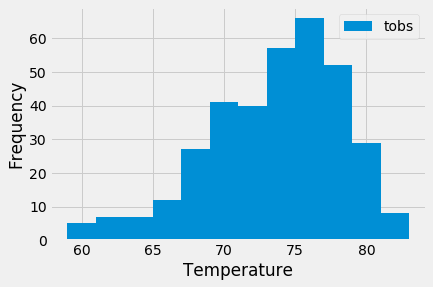

In [21]:
# Plot the results as a histogram
ast_df.plot(kind="hist", bins = 12)
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.show()

## Bonus Challenge Assignment

In [22]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [23]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [24]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [25]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [26]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [27]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [28]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [29]:
# Plot the daily normals as an area plot with `stacked=False`
